In [32]:
# Import Standard Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Import Machine Learning Libraries 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [34]:
# Read CSV Files 
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [35]:
# Explore the data
train_df.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [36]:
# Basic data pre-processing 
print('Data Shape: \n', train_df.shape)
print('Missing values \n', train_df.isnull().sum())

Data Shape: 
 (630000, 13)
Missing values 
 id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


In [37]:
# Basic Feature Engineering 

# Define column names as lists 
categorical_cols = ['gender', 'course', 'internet_access', 'study_method']
ordinal_cols = ['exam_difficulty', 'facility_rating', 'sleep_quality']
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Now extract the actual data
categorical_data = train_df[categorical_cols]
ordinal_data = train_df[ordinal_cols]
numerical_data = train_df[numerical_cols]

# Apply one-got encoder to categorical data
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(categorical_data)
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Data frame for categorical features
df_categorical_encoded = pd.DataFrame(
    encoded_categorical, 
    columns=encoded_feature_names,
    index=train_df.index
)

# Ordinal mapping
ordinal_mappings = {
    'sleep_quality': {'poor': 0, 'average': 1, 'good': 2},
    'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
    'exam_difficulty': {'easy': 0, 'moderate': 1, 'hard': 2}
}

df_ordinal_encoded = train_df[ordinal_cols].copy()
for col, mapping in ordinal_mappings.items():
    df_ordinal_encoded[col] = df_ordinal_encoded[col].map(mapping)

# Combine all features
train_df_processed = pd.concat([
    numerical_data,
    df_categorical_encoded,
    df_ordinal_encoded,
], axis=1)

print('DataFrame shape: \n', train_df_processed.shape)
print('\n Column Names: \n', train_df_processed.columns.tolist())


DataFrame shape: 
 (630000, 22)

 Column Names: 
 ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score', 'gender_male', 'gender_other', 'course_b.sc', 'course_b.tech', 'course_ba', 'course_bba', 'course_bca', 'course_diploma', 'internet_access_yes', 'study_method_group study', 'study_method_mixed', 'study_method_online videos', 'study_method_self-study', 'exam_difficulty', 'facility_rating', 'sleep_quality']


In [38]:
train_df_processed.head()

,id,age,study_hours,class_attendance,sleep_hours,exam_score,gender_male,gender_other,course_b.sc,course_b.tech,...,course_bca,course_diploma,internet_access_yes,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,exam_difficulty,facility_rating,sleep_quality
0,0,21,7.91,98.8,4.9,78.3,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
1,1,18,4.95,94.8,4.7,46.7,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,1,0
2,2,20,4.68,92.6,5.8,99.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,2,0
3,3,19,2.00,49.5,8.3,63.9,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,2,1
4,4,23,7.65,86.9,9.6,100.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,2,2


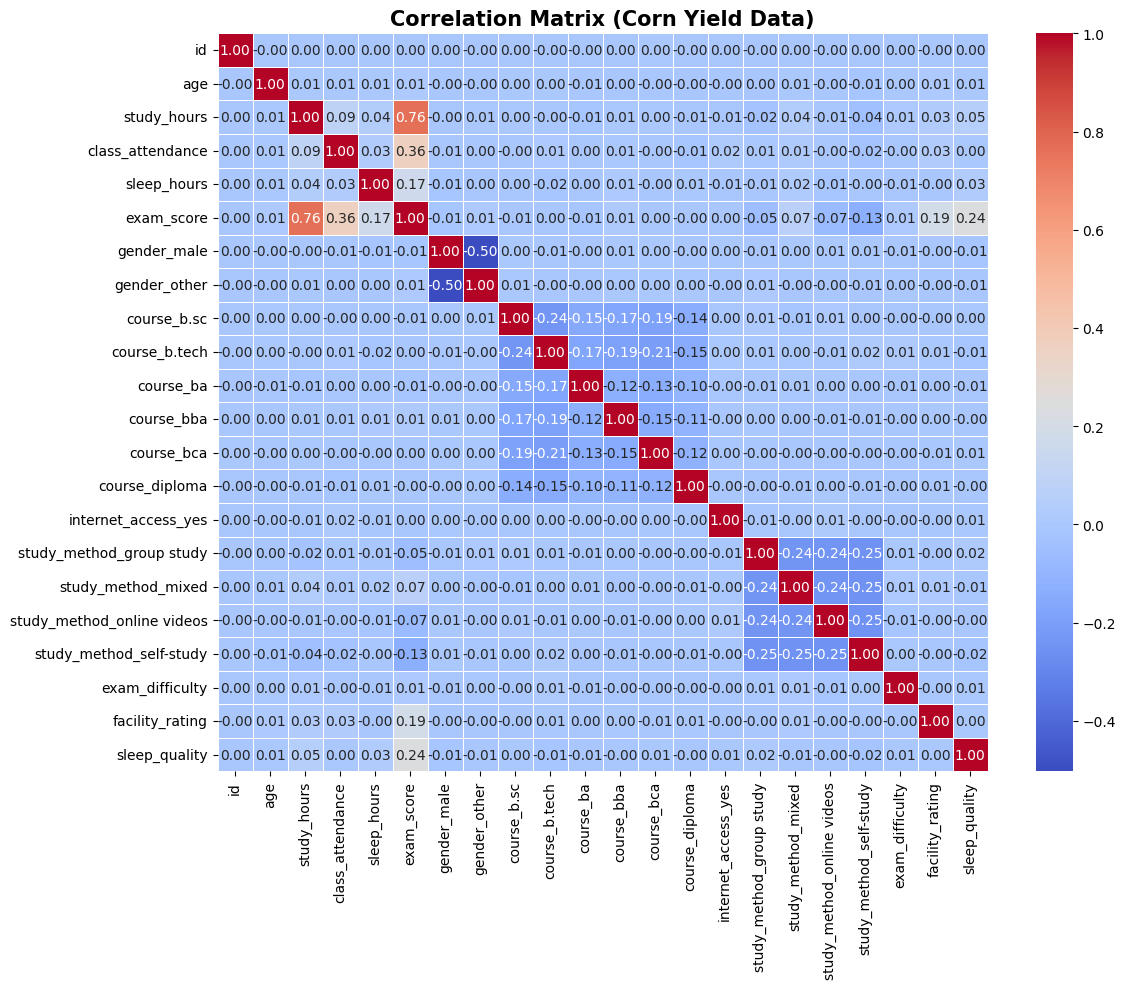

In [39]:
# Plot correlation
corr = train_df_processed.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Corn Yield Data)", fontsize=15, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [40]:
# Select features and create split

features = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'gender_male', 'gender_other', 'course_b.sc', 'course_b.tech', 'course_ba', 'course_bba', 'course_bca', 'course_diploma', 'internet_access_yes', 'study_method_group study', 'study_method_mixed', 'study_method_online videos', 'study_method_self-study', 'exam_difficulty', 'facility_rating', 'sleep_quality']

X = train_df_processed[features]
y = train_df_processed['exam_score']

# Train-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

# Print lengths of train/val/test data
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 455175, Validation: 80325, Test: 94500


In [41]:
# Scale features 
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_val_scaled = scalar.fit_transform(X_val)
X_test_scaled = scalar.fit_transform(X_test)

In [25]:
# Train model

rf_candidates =  [10, 15, 20, 100, 150, 200]

# Store Scores
train_rmse = []
val_rmse = []

for nbr in rf_candidates:
    RF = RandomForestRegressor(
        n_estimators=nbr,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    RF.fit(X_train, y_train)

    # Training 
    y_pred_train = RF.predict(X_train)
    train_rmse.append(root_mean_squared_error(y_train, y_pred_train))

    # Validation
    y_pred_val = RF.predict(X_val)
    val_rmse.append(root_mean_squared_error(y_val, y_pred_val))

# DataFrame for final output 
df_rf = pd.DataFrame([rf_candidates, train_rmse, val_rmse])
df_rf = df_rf.transpose()
df_rf.columns = ['Num Trees', 'Train RMSE', 'Val RMSE']
df_rf

,Num Trees,Train RMSE,Val RMSE
0,10.0,4.978588,9.483171
1,15.0,4.816735,9.362116
2,20.0,4.738124,9.298601
3,100.0,4.541696,9.143379
4,150.0,4.524684,9.129941
5,200.0,4.517047,9.122574


In [42]:
# XGB

xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

results = []

for n_est in [200, 300, 400]:
    for depth in [5, 7, 9]:
        for lr in [0.01, 0.05, 0.1]:
            XGB = xgb.XGBRegressor(
                n_estimators=n_est,
                max_depth=depth,
                learning_rate=lr,
                random_state=42,
                n_jobs=-1
            )
            XGB.fit(X_train, y_train)
            
            val_rmse = root_mean_squared_error(y_val, XGB.predict(X_val))
            
            results.append({
                'n_estimators': n_est,
                'max_depth': depth,
                'learning_rate': lr,
                'val_rmse': val_rmse
            })

df_results = pd.DataFrame(results)
print(df_results.nsmallest(5, 'val_rmse'))


    n_estimators  max_depth  learning_rate  val_rmse
20           400          5           0.10  8.807374
14           300          7           0.10  8.812196
23           400          7           0.10  8.812318
22           400          7           0.05  8.814638
11           300          5           0.10  8.816733


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define focused parameter grid
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.08, 0.10, 0.12],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on validation set
best_model = grid_search.best_estimator_
val_rmse = root_mean_squared_error(y_val, best_model.predict(X_val))
print(f"Validation RMSE: {val_rmse:.6f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
